In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.max_rows = 2000
import matplotlib
matplotlib.rcParams['figure.figsize'] = (24,4)
matplotlib.style.use('ggplot')
#data <- read.csv("C:/Users/p0p/Desktop/anaomaly/Example-3.csv", sep=",")

In [2]:
data = pd.read_csv(os.getcwd() + "\\3.csv")

In [3]:
data['time'] = pd.to_datetime(data.time)
data = data.set_index('time')
#data['new_col'] = data['value'].rolling(144).mean()

In [4]:
from datetime import date
from dateutil.rrule import rrule, DAILY
a = date(2013, 12, 1)
b = date(2014, 5, 31)
k = []
# Monday is 0 and Sunday is 6
for dt in rrule(DAILY, dtstart=a, until=b):
    k.append(np.append(dt.weekday(),data[dt.strftime("%Y-%m-%d")].value.values.reshape(144,)))
    data.loc[dt.strftime("%Y-%m-%d"),'weekday'] = dt.weekday()

In [7]:
data

,value,weekday
time,,
2013-12-01 00:00:00,4.07,6.0
2013-12-01 00:10:00,4.03,6.0
2013-12-01 00:20:00,4.04,6.0
2013-12-01 00:30:00,4.14,6.0
2013-12-01 00:40:00,4.07,6.0
2013-12-01 00:50:00,4.02,6.0
2013-12-01 01:00:00,4.00,6.0
2013-12-01 01:10:00,4.07,6.0
2013-12-01 01:20:00,4.21,6.0


In [85]:
for dt in rrule(DAILY, dtstart=a, until=b):
    if (dt.strftime("%Y-%m-%d") in ("2013-12-09", "2014-01-17", "2014-01-29", "2014-02-26", "2014-04-04", "2014-04-05", "2014-04-11", "2014-04-12",  "2014-04-22", "2014-04-30", "2014-05-12", "2014-05-13", "2014-05-26")):
        data.loc[dt.strftime("%Y-%m-%d"),'label_Answer'] = 1
    else:
        data.loc[dt.strftime("%Y-%m-%d"),'label_Answer'] = 0

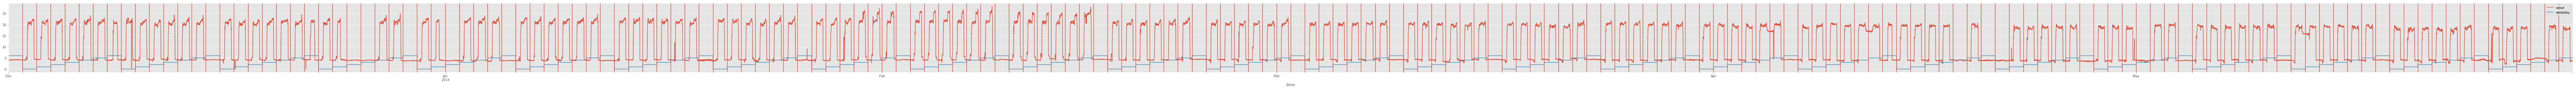

In [8]:
data.loc[:,['value','weekday']].plot(figsize=(144, 4))
for dt in rrule(DAILY, dtstart=a, until=b):
    plt.axvline(x=dt.strftime("%Y-%m-%d"))

In [12]:
data.head()

,value,weekday,preds_svm_oneclass
time,,,
2013-12-01 00:00:00,4.07,6.0,1.0
2013-12-01 00:10:00,4.03,6.0,1.0
2013-12-01 00:20:00,4.04,6.0,1.0
2013-12-01 00:30:00,4.14,6.0,1.0
2013-12-01 00:40:00,4.07,6.0,1.0


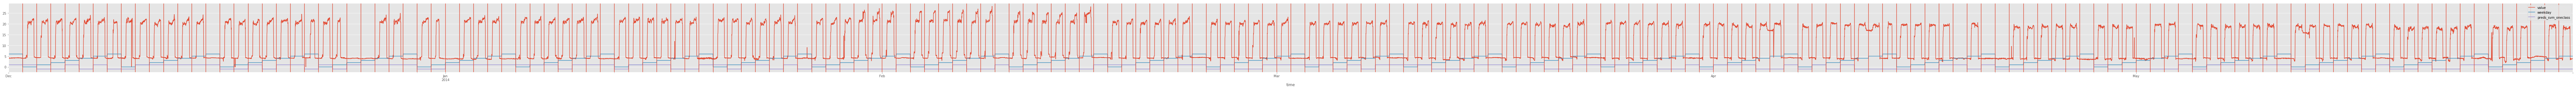

In [13]:
from sklearn.svm import OneClassSVM
abc = OneClassSVM()
abc.fit(np.array(k))
from sklearn import metrics 
preds = abc.predict(np.array(k)) 
# Monday is 0 and Sunday is 6
i = 0
for dt in rrule(DAILY, dtstart=a, until=b):
    data.loc[dt.strftime("%Y-%m-%d"),'preds_svm_oneclass'] = preds[i]
    i = i + 1
data.loc[:,['value','weekday','preds_svm_oneclass']].plot(figsize=(144, 4))
for dt in rrule(DAILY, dtstart=a, until=b):
    plt.axvline(x=dt.strftime("%Y-%m-%d"))


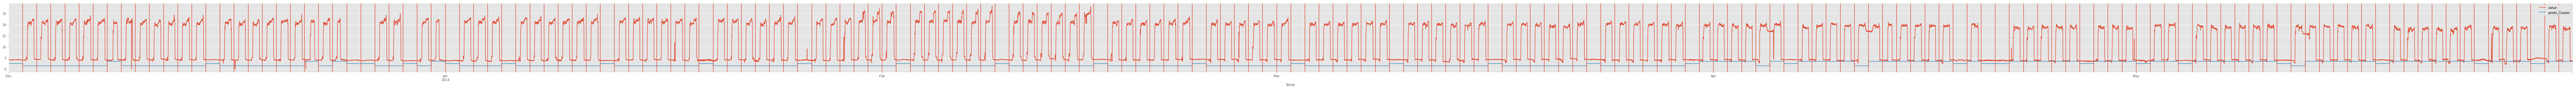

In [15]:
from sklearn.cluster import KMeans
X = np.array(k)
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
i = 0
for dt in rrule(DAILY, dtstart=a, until=b):
    data.loc[dt.strftime("%Y-%m-%d"),'preds_Cluster'] = kmeans.labels_[i]+1.5
    i = i +1
data.loc[:,['value','preds_Cluster']].plot(figsize=(144, 4))
for dt in rrule(DAILY, dtstart=a, until=b):
    plt.axvline(x=dt.strftime("%Y-%m-%d"))

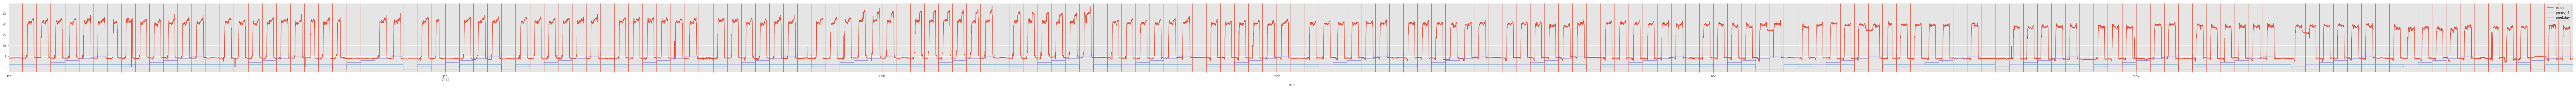

In [74]:
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X_train = np.array(k)
# Generate some regular novel observations


# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
i = 0
for dt in rrule(DAILY, dtstart=a, until=b):
    data.loc[dt.strftime("%Y-%m-%d"),'preds_rf'] = y_pred_train[i]
    i = i +1
data.loc[:,['value','preds_rf','weekday']].plot(figsize=(144, 4))
for dt in rrule(DAILY, dtstart=a, until=b):
    plt.axvline(x=dt.strftime("%Y-%m-%d"))

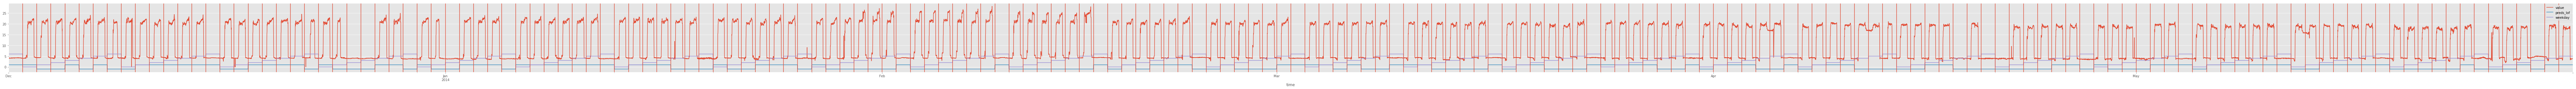

In [17]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=10,contamination=0.5)
y_pred = clf.fit_predict(np.array(k))
i = 0
for dt in rrule(DAILY, dtstart=a, until=b):
    data.loc[dt.strftime("%Y-%m-%d"),'preds_lof'] = y_pred[i]
    i = i +1
data.loc[:,['value','preds_lof','weekday']].plot(figsize=(144, 4))
for dt in rrule(DAILY, dtstart=a, until=b):
    plt.axvline(x=dt.strftime("%Y-%m-%d"))

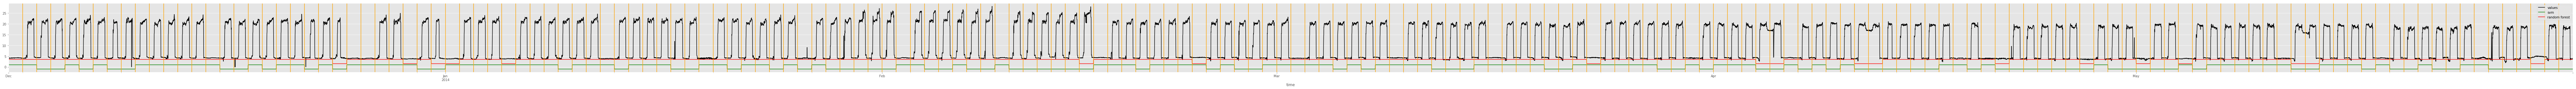

In [66]:
data.value.plot(color='black', label='values',figsize=(144, 4))
data.preds_svm_oneclass.plot(color='green', label='svm',figsize=(144, 4))
#data.preds_Cluster.plot(color='blue', label='kmeans',figsize=(144, 4))
data.preds_rf.plot(color='red', label='random forest',figsize=(144, 4))
for dt in rrule(DAILY, dtstart=a, until=b):
    plt.axvline(x=dt.strftime("%Y-%m-%d"),color='orange')
plt.legend(loc = 'best')

In [11]:
def smooth(x,window_len=144,window='hanning'):

    if window_len<3:
        return x

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
   # y = np.append(np.zeros(window_len) ,y) 
    return y
window_len=144
x = data['value'].values
y=smooth(x)
z = np.append(np.zeros(72) ,x) 
#plt.plot(y)
res2 = seasonal_decompose(y, model='additive', freq = 144*7)
res2.plot()

NameError: name 'seasonal_decompose' is not defined

In [ ]:
plt.plot(y)
j = 0
for i in range(1,34):
    plt.axvline(x=j)
    j = j + 144

plt.figure(figsize=(30,4))
plt.plot(res.resid)
plt.plot(data)
j = 0
for i in range(1,31):
    j = j + 144
    plt.axvline(x=data.index[j])

In [ ]:
from sklearn.cluster import KMeans
X = np.array(data).reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.labels_

In [ ]:
kmeans.labels_ *= 2

In [ ]:
plt.plot(kmeans.labels_)
plt.plot(data['value'].values)

In [ ]:
for i, j in enumerate(kmeans.labels_):
    if j == 3:
        print(data)

In [ ]:
#from statsmodels.nonparametric.smoothers_lowess import lowess
#filtered = lowess(data['value'].values, np.arange(1,len(data['value'].values)+1), is_sorted=True, frac=0.025, it=0)
#data['value'].plot(figsize=(30, 4), x='time',y='value',style='k--')
#plot(filtered[:,0], filtered[:,1], 'b')

In [ ]:
#leap = []
#for each in data.index:
#    if each.dayofweek == 6:
#        leap.append(each)
#dates = data.drop(leap)

In [ ]:
#a = np.array([3.4,3.1, 3.0, 2.9, 2.9, 3.0 ,5.4 ,11.3, 811.7, 10.3, 10.0 ,8.5, 8.3, 7.4 ,6.8 ,6.4 ,7.4 ,10.5 ,13.8, 12.4 ,10.4 ,8.9, 8.3, 6.0])

In [ ]:
# from xgboost import XGBClassifier
# from collections import Counter
# from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
# X =  np.X = np.zeros(shape=(31,144))
# y = np.zeros(shape=(31,)) 
# j = '20121201'
# for i in range(1,31):
    # X[i] = data.loc[j]['value'].values
    # j = str((int(j)+1)) 
# y[2] = y[3] = 1
# clf = XGBClassifier()
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=0)
# sm = SMOTE(random_state=42)
# X_res_train, y_res_train = sm.fit_sample(X_train, y_train)
# X_res_test, y_res_test = sm.fit_sample(X_test, y_test)
# clf.fit(X_res_train, y_res_train)
# score = clf.score(X_res_test, y_res_test)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
#ax = data.loc['20121203':'20121210']['value'].plot(figsize=(30, 4),style='k--')
ax = data['value'].plot(figsize=(30, 4),style='k--')
j = 0
for i in range(1,31):
    j = j + 144
    plt.axvline(x=data.index[j])
#data['new_col'].plot(ax = ax)
res = seasonal_decompose(data, model='additive', freq = 144*7)
fig = plt.figure() 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 4
res.trend.plot()
j = 0
for i in range(1,31):
    j = j + 144
    fig = plt.axvline(x=data.index[j])
res.seasonal.plot()
j = 0
for i in range(1,31):
    j = j + 144
    fig = plt.axvline(x=data.index[j])
res.resid.plot() 
j = 0
for i in range(1,31):
    j = j + 144
    fig = plt.axvline(x=data.index[j])

In [19]:
len(k)

182